<a href="https://colab.research.google.com/github/AdrianUrbanski/ADM/blob/main/lista3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn import linear_model

In [140]:
!pip install pyts
from pyts.classification import LearningShapelets
from pyts.utils import windowed_view

  Created wheel for pyt: filename=pyt-1.0.5-cp37-none-any.whl size=16733 sha256=ba50a4424b785c64bf8944911ffa22d3ae9e4bcb26bdf83ab4a8556a927d011b
  Stored in directory: /root/.cache/pip/wheels/be/3f/a9/4cbb498685229707566f778d12d51351fb15c8e688a7fab2f3
Successfully built pyt


ModuleNotFoundError: ignored

In [ ]:
!pip install surprise
from surprise import Dataset
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise.dataset import DatasetAutoFolds
from IPython.display import clear_output

     |████████████████████████████████| 11.8MB 333kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617554 sha256=98ac8e5b44ac619c124b77a5ab27083f766e73177baabdf55436d5b3b21460c5
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# Assignment 1

## a)

In [ ]:
def subsequence_dist(timeseries, shapelet):
    best_dist = np.infty

    for start in range(len(timeseries) - len(shapelet) + 1):
        dist = np.sum((timeseries[start:start + len(shapelet)] - shapelet)**2)
        if dist < best_dist:
            best_dist = dist

    return best_dist

In [ ]:
def info_gain(distances, labels, split):
    def entropy(labels):
        p_A = (labels == 0).sum() / len(labels)
        p_B = (labels == 1).sum() / len(labels)
        return -(p_A*np.log(p_A + np.exp(-100)) + p_B*np.log(p_B + np.exp(-100)))
        
    labels_1 = labels[np.where(distances < split)]
    fraction_1 = len(labels_1) / len(labels)
    labels_2 = labels[np.where(distances >= split)]
    fraction_2 = len(labels_2) / len(labels)

    if fraction_1 == 0 or fraction_2 == 0:
        return 0

    return entropy(labels) - (fraction_1*entropy(labels_1) + fraction_2*entropy(labels_2))

In [ ]:
def finding_shapelet_bf(dataset, labels, minlen, maxlen, n_best=1):
    def generate_candidates(dataset, minlen, maxlen):
        pool = set()
        for timeseries in dataset:
            for shapelet_length in range(minlen, maxlen+1):
                for start in range(len(timeseries) - shapelet_length + 1):
                    pool.add(tuple(timeseries[start:start+shapelet_length]))
        return pool

    def calculate_information_gain(distances, labels):
        best_gain = 0
        for split_point in np.unique(distances):
            gain = info_gain(distances, labels, split_point)
            if gain > best_gain:
                best_gain = gain

        return best_gain

    def check_candidate(dataset, shapelet, labels):
        distances = np.zeros(dataset.shape[0])
        for ts_idx in range(dataset.shape[0]):
            distances[ts_idx] = subsequence_dist(dataset[ts_idx], shapelet)

        return calculate_information_gain(distances, labels)

    candidates = generate_candidates(dataset, minlen, maxlen)

    gains = np.zeros(len(candidates))

    best_gain = 0
    best_shapelet = None

    for shapelet in candidates:
        gain = check_candidate(dataset, shapelet, labels)
        if gain > best_gain:
            best_gain = gain
            best_shapelet = shapelet

    return best_shapelet

## b)

In [ ]:
def generate_time_series(len=150, alpha=0.995):
    s = np.empty(len, dtype=float)
    s[0] = 0
    momentum = 0
    for pos in range(1, len):
        momentum = alpha*momentum + np.random.normal(0, 1)
        s[pos] = s[pos-1] + momentum
    s -= np.min(s)
    s /= np.max(s)
    return s

In [ ]:
def make_random_copy(s, len=100):
    base_len = s.shape[0]
    start = np.random.choice(base_len - len)
    return s[start: start+len]

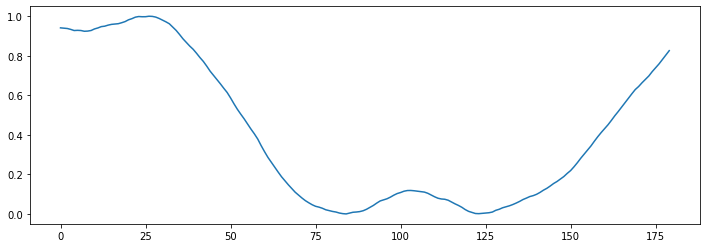

In [ ]:
plt.figure(figsize=(12,4))
base_time_series = generate_time_series(len=180)
plt.plot(base_time_series)

(0.0, 1.0)

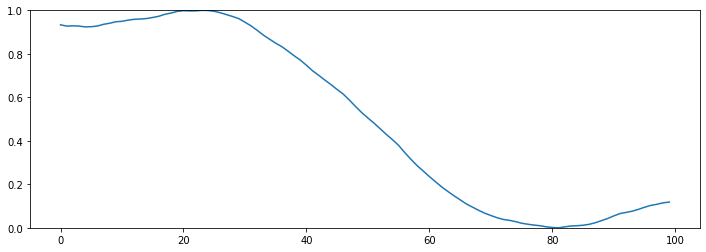

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(make_random_copy(base_time_series, len=100))
plt.ylim((0, 1))

In [ ]:
copies_count = 30
len_base = 90
len_copy = 50

ts1, ts2 = generate_time_series(len=len_base), generate_time_series(len=len_base)

dataset = np.empty((2*copies_count, len_copy))
labels = np.hstack((np.zeros(copies_count),
                    np.ones(copies_count)))

for copy_idx in range(copies_count):
    dataset[copy_idx] = make_random_copy(ts1, len=len_copy)
    dataset[copies_count + copy_idx] = make_random_copy(ts2, len=len_copy)

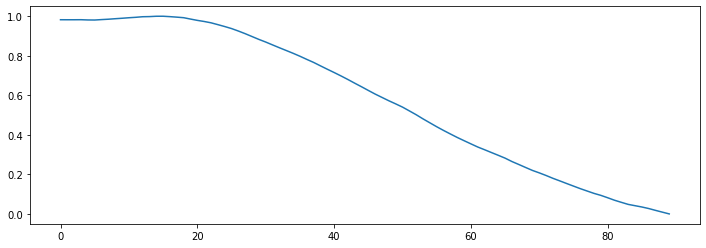

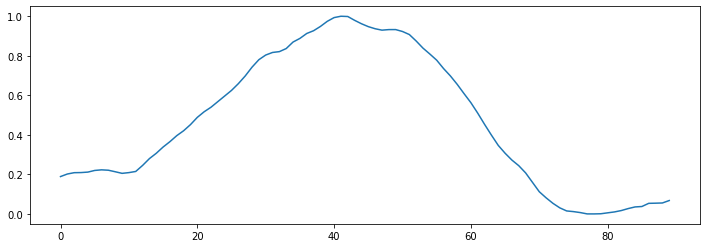

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(ts1)
plt.figure(figsize=(12,4))
plt.plot(ts2)

In [ ]:
shapelet = finding_shapelet_bf(dataset, labels, 10, 10)

0.0014155953940940863
0.0


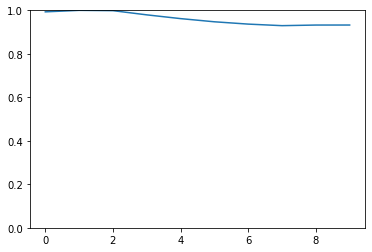

In [ ]:
plt.plot(shapelet)
plt.ylim((0, 1))

print(subsequence_dist(ts1, shapelet))
print(subsequence_dist(ts2, shapelet))

## c)

In [ ]:
def subsequence_dist(timeseries, shapelet):
    best_dist = np.infty

    for start in range(len(timeseries) - len(shapelet) + 1):
        dist = np.sum((timeseries[start:start + len(shapelet)] - shapelet)**2)
        if dist < best_dist:
            best_dist = dist

    return best_dist

In [ ]:
def info_gain(distances, labels, split):
    def entropy(labels):
        p_A = (labels == 0).sum() / len(labels)
        p_B = (labels == 1).sum() / len(labels)
        return -(p_A*np.log(p_A + np.exp(-100)) + p_B*np.log(p_B + np.exp(-100)))
        
    labels_1 = labels[np.where(distances < split)]
    fraction_1 = len(labels_1) / len(labels)
    labels_2 = labels[np.where(distances >= split)]
    fraction_2 = len(labels_2) / len(labels)

    if fraction_1 == 0 or fraction_2 == 0:
        return 0

    return entropy(labels) - (fraction_1*entropy(labels_1) + fraction_2*entropy(labels_2))

In [ ]:
def finding_shapelet_pruning(dataset, labels, minlen, maxlen, n_best=1):
    def generate_candidates(dataset, minlen, maxlen):
        pool = set()
        for timeseries in dataset:
            for shapelet_length in range(minlen, maxlen+1):
                for start in range(len(timeseries) - shapelet_length + 1):
                    pool.add(tuple(timeseries[start:start+shapelet_length]))
        return pool

    def calculate_information_gain(distances, labels):
        best_gain = 0
        for split_point in np.unique(distances):
            gain = info_gain(distances, labels, split_point)
            if gain > best_gain:
                best_gain = gain

        return best_gain

    def check_candidate(dataset, shapelet, labels, best_gain_so_far):
        def entropy_early_prune(best_gain_so_far, distances_A, distances_B, labels):
            if calculate_information_gain(distances_A, labels) > best_gain_so_far:
                return False
            if calculate_information_gain(distances_B, labels) > best_gain_so_far:
                return False
            return True

        distances_A = np.zeros(dataset.shape[0])
        distances_B = np.zeros(dataset.shape[0])
        distances_A[labels == 0] = np.inf
        distances_B[labels == 1] = np.inf
        for ts_idx in range(dataset.shape[0]):
             dist = subsequence_dist(dataset[ts_idx], shapelet)
             distances_A[ts_idx], distances_B[ts_idx] = dist, dist

             if entropy_early_prune(best_gain_so_far, distances_A, distances_B, labels):
                 return 0

        return calculate_information_gain(distances_A, labels)

    candidates = generate_candidates(dataset, minlen, maxlen)

    gains = np.zeros(len(candidates))

    best_gain = 0
    best_shapelet = None

    for shapelet in candidates:
        gain = check_candidate(dataset, shapelet, labels, best_gain)
        if gain > best_gain:
            best_gain = gain
            best_shapelet = shapelet

    return best_shapelet

In [ ]:
def generate_time_series(len=150, alpha=0.995):
    s = np.empty(len, dtype=float)
    s[0] = 0
    momentum = 0
    for pos in range(1, len):
        momentum = alpha*momentum + np.random.normal(0, 1)
        s[pos] = s[pos-1] + momentum
    s -= np.min(s)
    s /= np.max(s)
    return s

In [ ]:
def make_random_copy(s, len=100):
    base_len = s.shape[0]
    start = np.random.choice(base_len - len)
    return s[start: start+len]

In [ ]:
copies_count = 30
len_base = 90
len_copy = 50

ts1, ts2 = generate_time_series(len=len_base), generate_time_series(len=len_base)

dataset = np.empty((2*copies_count, len_copy))
labels = np.hstack((np.zeros(copies_count),
                    np.ones(copies_count)))

for copy_idx in range(copies_count):
    dataset[copy_idx] = make_random_copy(ts1, len=len_copy)
    dataset[copies_count + copy_idx] = make_random_copy(ts2, len=len_copy)

In [ ]:
%time shapelet1 = finding_shapelet_bf(dataset, labels, 10, 10)
pass

CPU times: user 4.57 s, sys: 9.66 ms, total: 4.58 s
Wall time: 4.59 s


In [ ]:
%time shapelet2 = finding_shapelet_pruning(dataset, labels, 10, 10)
pass

CPU times: user 339 ms, sys: 2.98 ms, total: 342 ms
Wall time: 346 ms


In [ ]:
print(subsequence_dist(ts1, shapelet1))
print(subsequence_dist(ts2, shapelet1))

print(subsequence_dist(ts1, shapelet2))
print(subsequence_dist(ts2, shapelet2))

0.004078631401217629
0.0
0.004078631401217629
0.0


# Assignment 2

## Gunpoint dataset

In [ ]:
from pyts.datasets import load_gunpoint

In [ ]:
X, _, y, _ = load_gunpoint(return_X_y=True)

In [ ]:
X.shape

(50, 150)

In [ ]:
y.shape

(50,)

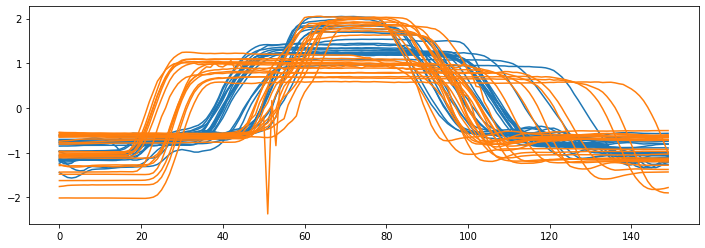

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(X[y==1].T, '#1F77B4')
plt.plot(X[y==2].T, '#FF7F0E')
plt.show()

### Finding shapelets

In [ ]:
clf = LearningShapelets(random_state=42, tol=0.01)
clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


LearningShapelets(C=1000, alpha=-100, class_weight=None, fit_intercept=True,
                  intercept_scaling=1.0, learning_rate=1.0, max_iter=1000,
                  min_shapelet_length=0.1, multi_class='multinomial',
                  n_jobs=None, n_shapelets_per_size=0.2, penalty='l2',
                  random_state=42, shapelet_scale=3, tol=0.01, verbose=0)

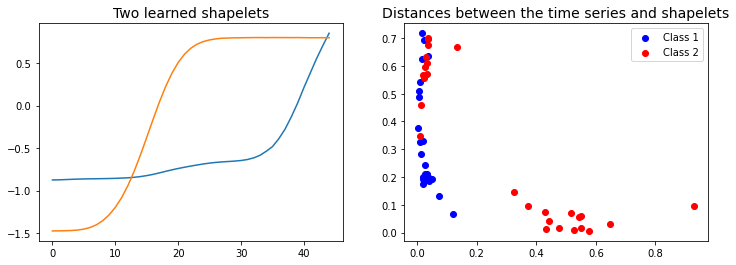

In [ ]:
shapelets = np.asarray([clf.shapelets_[0, -9], clf.shapelets_[0, -12]])

shapelet_size = shapelets.shape[1]
X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
X_dist = np.mean((X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)

# Plot shapelets
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(shapelets[0])
plt.plot(shapelets[1])
plt.title('Two learned shapelets', fontsize=14)

# Plot distances
plt.subplot(1, 2, 2)
for color, label in zip('br', (1, 2)):
    plt.scatter(X_dist[y == label, 0], X_dist[y == label, 1],
                c=color, label='Class {}'.format(label))
plt.title('Distances between the time series and shapelets', fontsize=14)
plt.legend()
plt.show()

### Examples of shapelets

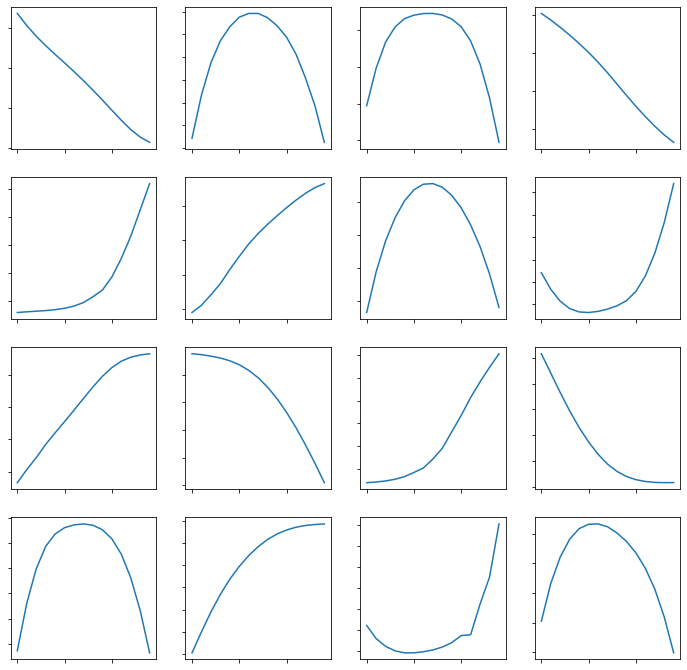

In [ ]:
plt.figure(figsize=(12,12))
for i in range(16):
    ax = plt.subplot(4, 4, 1 + i)
    ax.plot(clf.shapelets_[0, i])
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)


### Shapelets in time series

In [ ]:
starting_points = np.argmin(np.mean((X_window[:, :, None] - shapelets[None, :])**2, axis=3), axis=1)

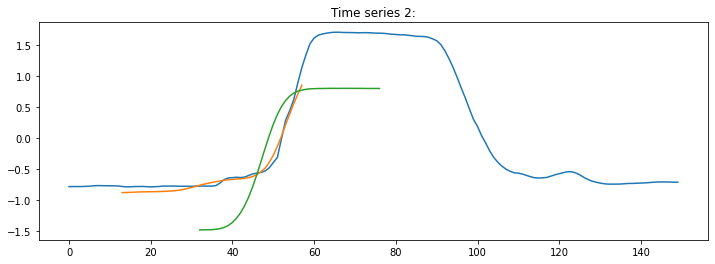

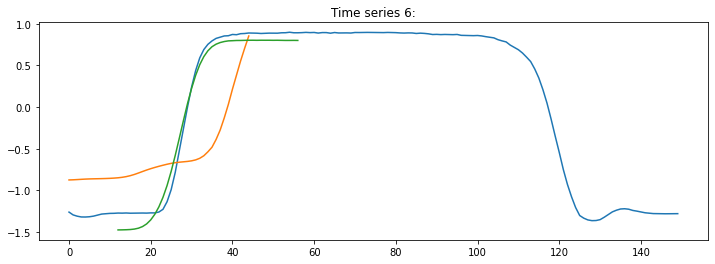

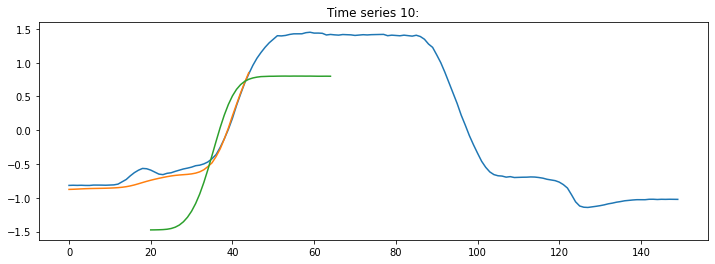

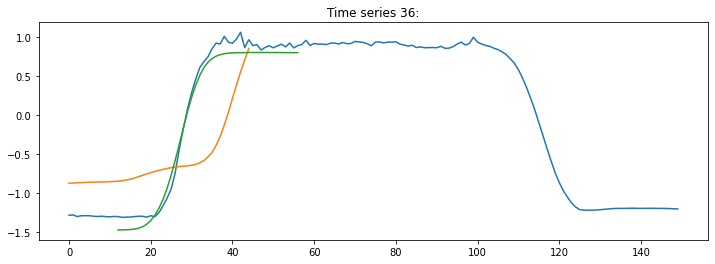

In [ ]:
for ts_idx in (2, 6, 10, 36):
    plt.figure(figsize=(12,4))
    plt.title(f'Time series {ts_idx}:')
    plt.plot(X[ts_idx].T)
    for shapelet_idx in range(shapelets.shape[0]):
        start = starting_points[ts_idx][shapelet_idx]
        plt.plot(np.arange(start, start+shapelet_size),
                shapelets[shapelet_idx])

## Arrow head dataset

In [ ]:
df = pd.read_csv('ArrowHead_TRAIN.txt', delimiter='  ', header=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


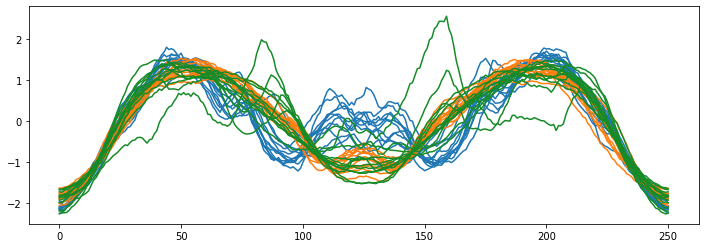

In [ ]:
X = np.asarray(df.iloc[:, 1:])
y = np.asarray(df.iloc[:, 0])

plt.figure(figsize=(12,4))
plt.plot(X[y==0].T, '#1F77B4')
plt.plot(X[y==1].T, '#FF7F0E')
plt.plot(X[y==2].T, '#158B27')
plt.show()

### Finding shapelets

In [ ]:
clf = LearningShapelets(random_state=42, tol=0.01)
clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


LearningShapelets(C=1000, alpha=-100, class_weight=None, fit_intercept=True,
                  intercept_scaling=1.0, learning_rate=1.0, max_iter=1000,
                  min_shapelet_length=0.1, multi_class='multinomial',
                  n_jobs=None, n_shapelets_per_size=0.2, penalty='l2',
                  random_state=42, shapelet_scale=3, tol=0.01, verbose=0)

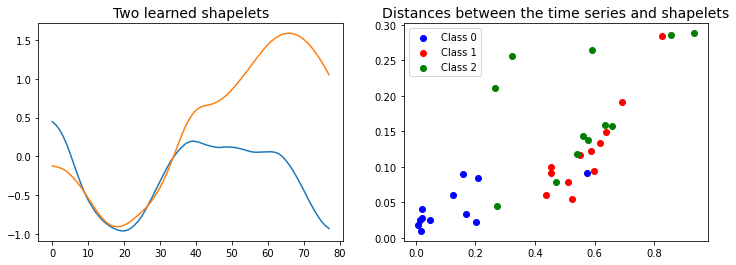

In [ ]:
shapelets = np.asarray([clf.shapelets_[0, -9], clf.shapelets_[0, -6]])

shapelet_size = shapelets.shape[1]
X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
X_dist = np.mean((X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)

# Plot shapelets
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(shapelets[0])
plt.plot(shapelets[1])
plt.title('Two learned shapelets', fontsize=14)

# Plot distances
plt.subplot(1, 2, 2)
for color, label in zip('brg', (0, 1, 2)):
    plt.scatter(X_dist[y == label, 0], X_dist[y == label, 1],
                c=color, label='Class {}'.format(label))
plt.title('Distances between the time series and shapelets', fontsize=14)
plt.legend()
plt.show()

### Examples of shapelets

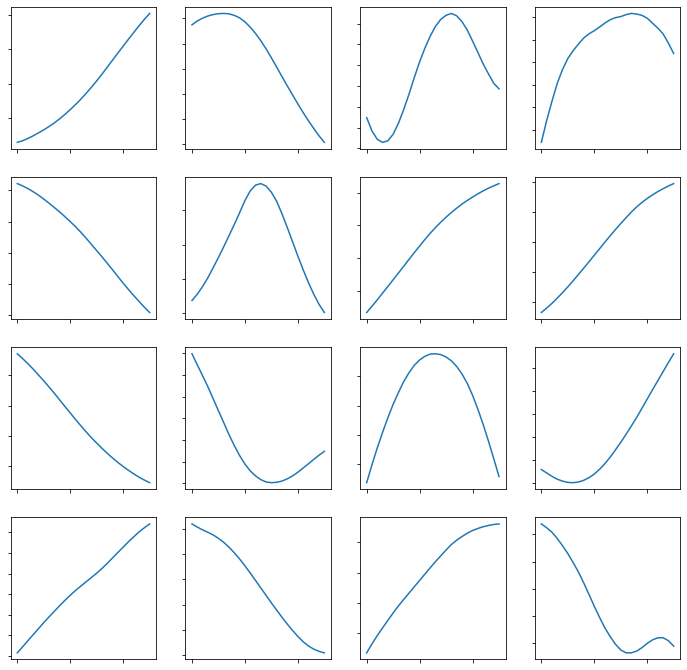

In [ ]:
plt.figure(figsize=(12,12))
for i in range(16):
    ax = plt.subplot(4, 4, 1 + i)
    ax.plot(clf.shapelets_[0, i])
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)


### Shapelets in time series

In [ ]:
X.shape

(36, 251)

In [ ]:
X_window.shape

(36, 174, 78)

In [ ]:
starting_points = np.argmin(np.mean((X_window[:, :, None] - shapelets[None, :])**2, axis=3), axis=1)

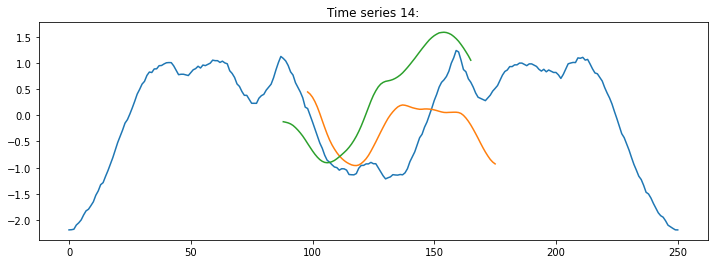

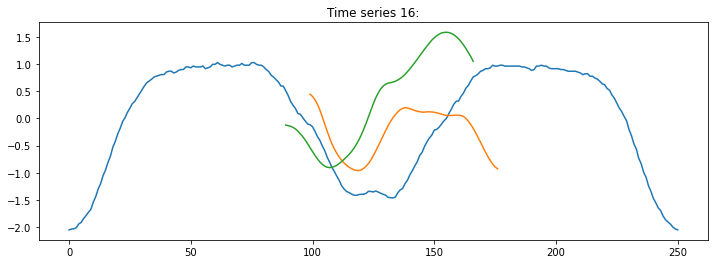

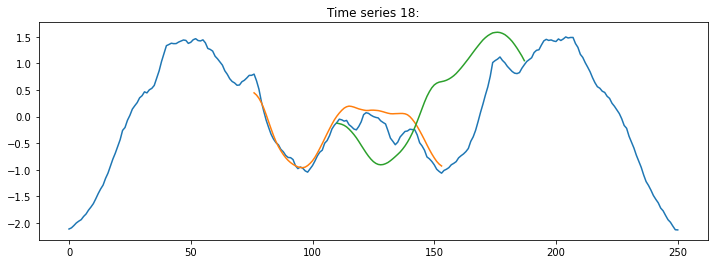

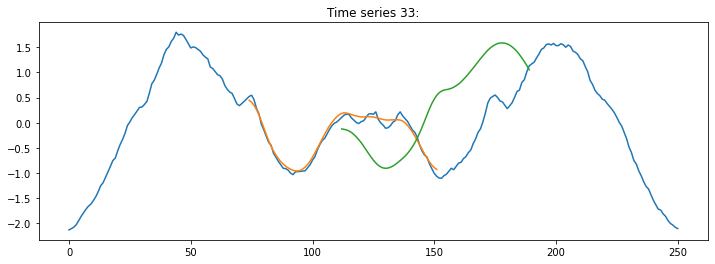

In [ ]:
for ts_idx in (14, 16, 18, 33):
    plt.figure(figsize=(12,4))
    plt.title(f'Time series {ts_idx}:')
    plt.plot(X[ts_idx].T)
    for shapelet_idx in range(shapelets.shape[0]):
        start = starting_points[ts_idx][shapelet_idx]
        plt.plot(np.arange(start, start+shapelet_size),
                shapelets[shapelet_idx])

# Assignment 3

## Utilities

In [2]:
def plot_raw_prediction(df):
    plt.figure(figsize=(12,4))
    df['preprocessed'].plot(label='preprocessed data')
    df['prediction_raw'].plot(label='raw prediction')
    plt.axvline(split_date, color='r')
    plt.xlabel('Time')
    plt.ylabel('')
    plt.title('Airline Passengers')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def plot_prediction(ax, df, split_date=np.datetime64('1957-01-01')):
    df['prediction'].plot(ax=ax, label='predicted data')
    df['Passengers'].plot(ax=ax, label='original data')
    ax.axvline(split_date, color='r')
    ax.legend(loc='upper left')
    ax.set_xlabel('Time')
    ax.set_ylabel('Passengers')
    ax.set_title('Airline Passengers')

def plot_error(ax, df, test_size=48):
    (df['Passengers'] - df['prediction']).plot(ax=ax, kind='bar')
    ax.axvline(df.shape[0]-test_size, color='r')
    ax.set_xticks([])
    ax.set_xlabel('Time')
    ax.set_ylabel('Passengers')
    ax.set_title('Airline Passengers - Prediction Errors')

def plot_error_normalised(ax, df, test_size=48):
    plt.figure(figsize=(12,4))
    ((df['Passengers'] - df['prediction']) / df['Passengers']).plot(ax=ax, kind='bar')
    ax.axvline(df.shape[0]-test_size, color='r')
    ax.set_xticks([])
    ax.set_xlabel('Time')
    ax.set_ylabel('Passengers [in %]')
    ax.set_title('Airline Passengers - Prediction Percentage Errors')

In [4]:
def print_errors(df):
    print('MSE: %0.4f' % ((df['Passengers'] - df['prediction'])**2).mean())
    print('MAE: %0.4f' % (df['Passengers'] - df['prediction']).abs().mean())
    print('MAPE: %0.4f' % ((df['Passengers'] - df['prediction']) / df['Passengers']).abs().mean())

## Data loading and preprocessing

In [5]:
df = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=['Month'])
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [6]:
# preprocessing
df = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=['Month'])
df['trend'] = df['Passengers'].ewm(halflife=12).mean()
df['detrended'] = df['Passengers'] / df['trend']
df_seasonality = df['detrended'].groupby(df.index.month).mean().rename('seasonality')
df = df.join(df_seasonality, how='left', on=df.index.month)
df['preprocessed'] = df['detrended'] - df['seasonality']

## Splitting dataset

In [7]:
split_date = np.datetime64('1957-01-01')
train_size = (df.index < split_date).sum()
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]

## Prediction by previous value

In [369]:
y_predicted = np.zeros(len(df))
y_predicted[1:] = df['preprocessed'][:-1]

df['prediction_raw'] = y_predicted
df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

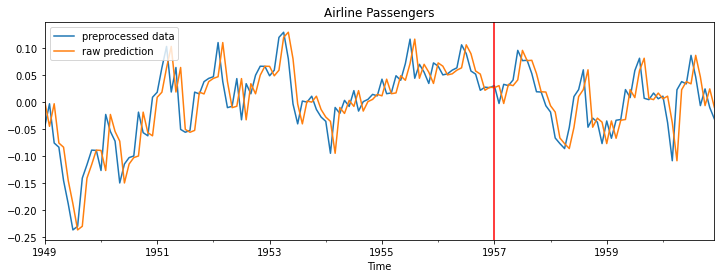

In [370]:
plot_raw_prediction(df)

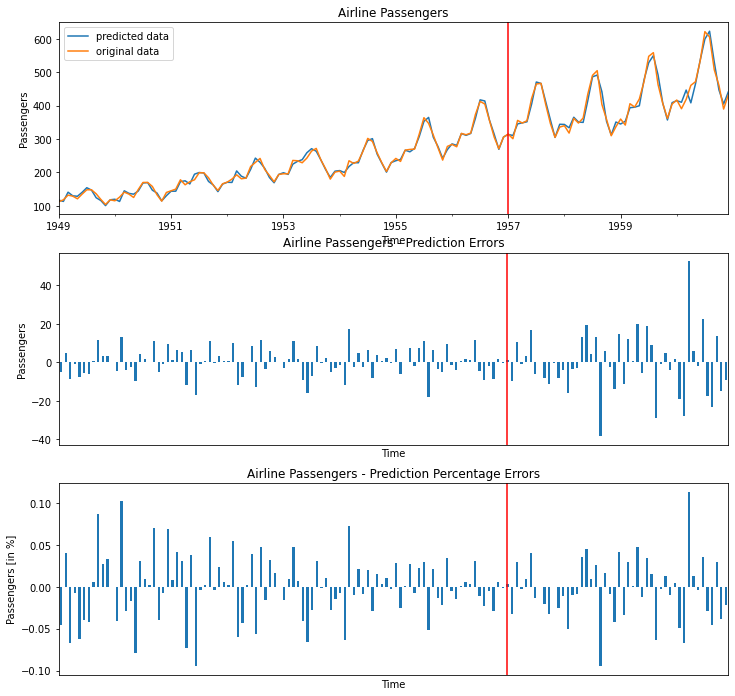

<Figure size 864x288 with 0 Axes>

In [371]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))
plot_prediction(ax1, df)
plot_error(ax2, df)
plot_error_normalised(ax3, df)

In [372]:
print_errors(df)

MSE: 113.5205
MAE: 7.5205
MAPE: 0.0279


In [373]:
print_errors(df[1:])

MSE: 114.1363
MAE: 7.5378
MAPE: 0.0278


## Prediction by multidimensional linear regression

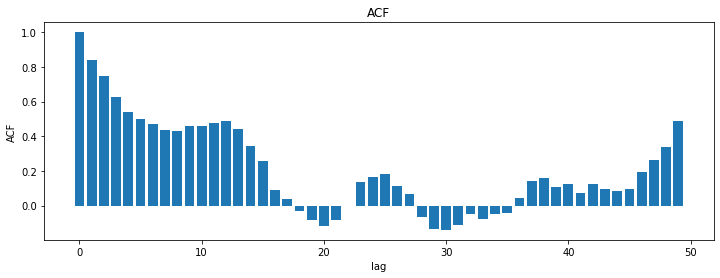

In [374]:
acf = np.zeros(50)
for lag in range(len(acf)):
    acf[lag] = np.corrcoef(train_df['preprocessed'][lag:], train_df['preprocessed'].shift(lag)[lag:])[0, 1]

plt.figure(figsize=(12,4))
plt.bar(range(len(acf)), acf)
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF')
plt.show()

In [433]:
prev_vals = 15
reg = linear_model.LinearRegression()

train_X = np.vstack([train_df['preprocessed'][:-1].shift(lag).values[prev_vals-1:] for lag in range(prev_vals)]).T
train_y = train_df['preprocessed'].values[prev_vals:]

reg.fit(train_X, train_y)

X = np.vstack([df['preprocessed'][:-1].shift(lag).values[prev_vals-1:] for lag in range(prev_vals)]).T
y_predicted = np.zeros(len(df))
y_predicted[prev_vals:] = reg.predict(X)

df['prediction_raw'] = y_predicted
df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

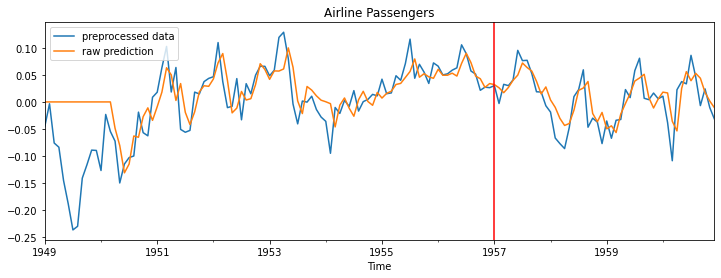

In [434]:
plot_raw_prediction(df)

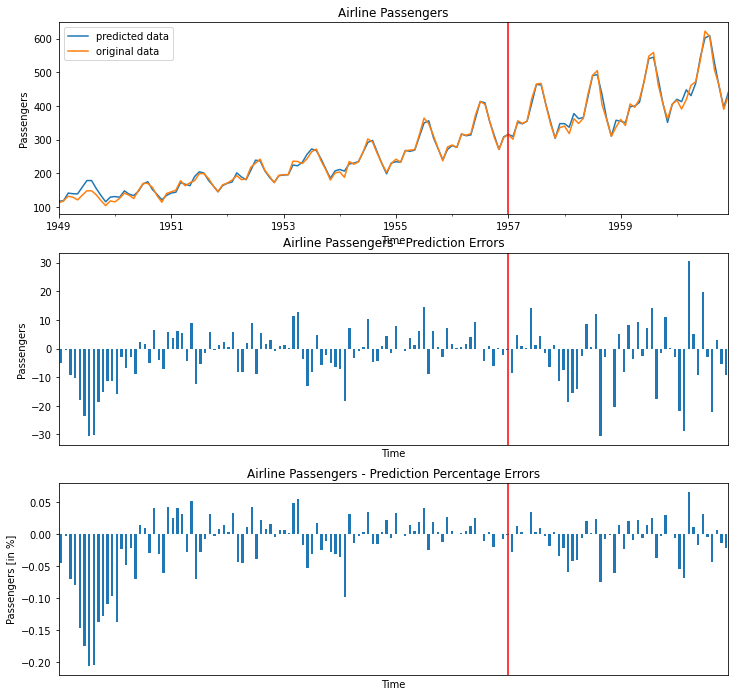

<Figure size 864x288 with 0 Axes>

In [435]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))
plot_prediction(ax1, df)
plot_error(ax2, df)
plot_error_normalised(ax3, df)

In [436]:
print_errors(df)

MSE: 99.4498
MAE: 7.1785
MAPE: 0.0313


In [437]:
print_errors(df[prev_vals:])

MSE: 79.3958
MAE: 6.3909
MAPE: 0.0224


## Prediction using LSTM

In [438]:
class LSTM(nn.Module):

    def __init__(self, input_size=1, hidden_dim=100, output_size=1, dropout=0):
        super().__init__()
        self.hidden_layer_size = hidden_dim

        self.lstm = nn.LSTM(input_size, hidden_dim, dropout=dropout, batch_first=True)

        self.linear = nn.Linear(hidden_dim, output_size)

        self.hidden_cell = None
    
    def forward(self, time_series):
        batch_size = time_series.shape[0]
        self.reset_hidden_cell(batch_size)
        lstm_out, self.hidden_cell = self.lstm(time_series.view(batch_size, -1, 1),
                                               self.hidden_cell)
        preds = self.linear(lstm_out.view(batch_size, -1, self.hidden_layer_size))
        return preds[:, -1, 0]

    def reset_hidden_cell(self, batch_size):
        self.hidden_cell = (torch.zeros(1, batch_size, self.hidden_layer_size),
                            torch.zeros(1, batch_size, self.hidden_layer_size))

In [439]:
prev_vals = 5

train_X = torch.tensor(np.vstack([train_df['preprocessed'][:-1].shift(lag).values[prev_vals-1:] for lag in range(prev_vals)]).T).float()
train_y = torch.tensor(train_df['preprocessed'].values[prev_vals:]).float()

In [440]:
model = LSTM(hidden_dim=100, dropout=0.5)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [441]:
epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(train_X)

    loss = loss_function(y_pred, train_y)
    loss.backward()
    optimizer.step()
    
    if epoch%250 == 0:
        print(f'epoch: {epoch} loss: {loss.item()}')

print(f'final loss: {loss.item()}')

epoch: 0 loss: 0.0074879941530525684
epoch: 250 loss: 0.001564185367897153
epoch: 500 loss: 0.0013810540549457073
epoch: 750 loss: 0.0013443843927234411
final loss: 0.0013300671707838774


In [443]:
X = torch.tensor(np.vstack([df['preprocessed'].shift(lag).values[prev_vals-1:] for lag in range(prev_vals)]).T).float()

with torch.no_grad():
    results = model(X)

y_predicted = np.zeros(len(df))
y_predicted[prev_vals-1:] = np.array(results)

df['prediction_raw'] = y_predicted
df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

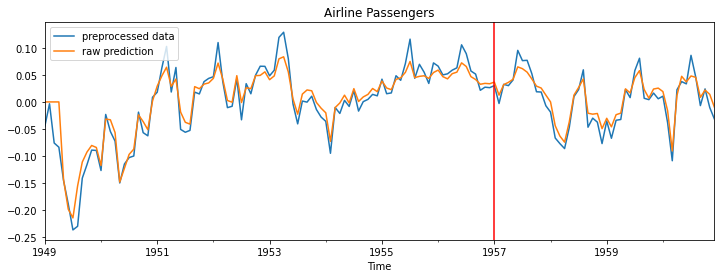

In [444]:
plot_raw_prediction(df)

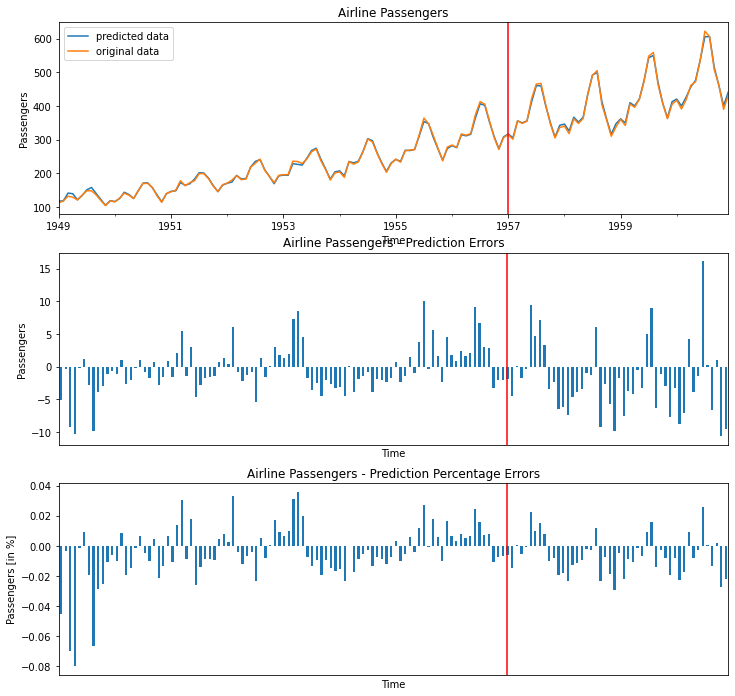

<Figure size 864x288 with 0 Axes>

In [445]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))
plot_prediction(ax1, df)
plot_error(ax2, df)
plot_error_normalised(ax3, df)

In [446]:
print_errors(df)

MSE: 20.0653
MAE: 3.4403
MAPE: 0.0131


In [447]:
print_errors(df[prev_vals+1:])

MSE: 19.3588
MAE: 3.3989
MAPE: 0.0122


## Prediction using GRU

In [448]:
class GRU(nn.Module):

    def __init__(self, input_size=1, hidden_dim=100, output_size=1, dropout=0):
        super().__init__()
        self.hidden_layer_size = hidden_dim

        self.lstm = nn.GRU(input_size, hidden_dim, dropout=dropout, batch_first=True)

        self.linear = nn.Linear(hidden_dim, output_size)

        self.hidden_cell = None
    
    def forward(self, time_series):
        batch_size = time_series.shape[0]
        self.reset_hidden_cell(batch_size)
        lstm_out, self.hidden_cell = self.lstm(time_series.view(batch_size, -1, 1),
                                               self.hidden_cell)
        preds = self.linear(lstm_out.view(batch_size, -1, self.hidden_layer_size))
        return preds[:, -1, 0]

    def reset_hidden_cell(self, batch_size):
        self.hidden_cell = (torch.zeros(1, batch_size, self.hidden_layer_size))

In [450]:
prev_vals = 5

train_X = torch.tensor(np.vstack([train_df['preprocessed'][:-1].shift(lag).values[prev_vals-1:] for lag in range(prev_vals)]).T).float()
train_y = torch.tensor(train_df['preprocessed'].values[prev_vals:]).float()

In [451]:
model = GRU(hidden_dim=100, dropout=0.5)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [452]:
epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(train_X)

    loss = loss_function(y_pred, train_y)
    loss.backward()
    optimizer.step()
    
    if epoch%250 == 0:
        print(f'epoch: {epoch} loss: {loss.item()}')

print(f'final loss: {loss.item()}')

epoch: 0 loss: 0.016819659620523453
epoch: 250 loss: 0.0016132370801642537
epoch: 500 loss: 0.0014023100957274437
epoch: 750 loss: 0.0013454011641442776
final loss: 0.0013209179742261767


In [453]:
X = torch.tensor(np.vstack([df['preprocessed'].shift(lag).values[prev_vals-1:] for lag in range(prev_vals)]).T).float()

with torch.no_grad():
    results = model(X)

y_predicted = np.zeros(len(df))
y_predicted[prev_vals-1:] = np.array(results)

df['prediction_raw'] = y_predicted
df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

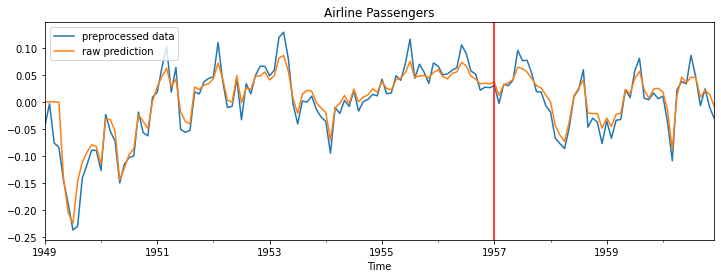

In [454]:
plot_raw_prediction(df)

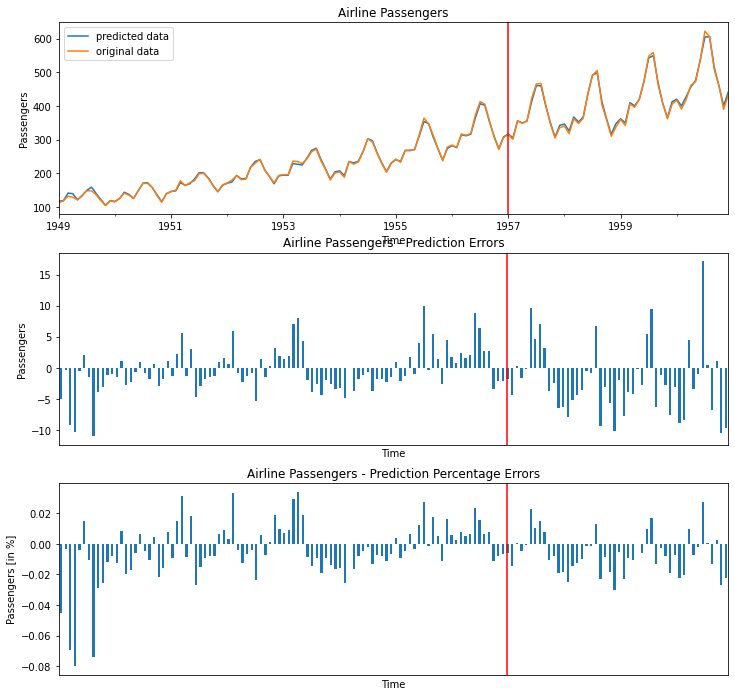

<Figure size 864x288 with 0 Axes>

In [455]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,12))
plot_prediction(ax1, df)
plot_error(ax2, df)
plot_error_normalised(ax3, df)

In [456]:
print_errors(df)

MSE: 20.7453
MAE: 3.4711
MAPE: 0.0133


In [458]:
print_errors(df[prev_vals:])

MSE: 19.9335
MAE: 3.4133
MAPE: 0.0124


# Assignment 4

## a) & b)

### MovieLens 100k

In [ ]:
data = Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [ ]:
names = ["KNNBasic_MSD", "KNNBasic_cosine", "KNNMeans_MSD", "KNNMeans_cosine", "SlopeOne",
         "SVD", "SVD++"]
algos = [KNNBasic(),
         KNNBasic(sim_options={'name':'cosine'}),
         KNNWithMeans(),
         KNNWithMeans(sim_options={'name':'cosine'}),
         SlopeOne(),
         SVD(),
         SVDpp()]

results = []
for name, algo in zip(names, algos):
    print(f'Calculating for {name}')
    stats = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5)
    results.append({
        'algo' : name,
        'fit_time': np.mean(stats['fit_time']),
        'test_mae': np.mean(stats['test_mae']),
        'test_rmse': np.mean(stats['test_rmse']),
        'test_time': np.mean(stats['test_time']),
    })
    clear_output()

In [ ]:
pd.DataFrame(results).set_index('algo')

,fit_time,test_mae,test_rmse,test_time
algo,,,,
KNNBasic_MSD,0.409341,0.773063,0.978720,4.020358
KNNBasic_cosine,1.023325,0.804702,1.017373,4.003088
KNNMeans_MSD,0.463139,0.749137,0.950515,4.195234
KNNMeans_cosine,1.068570,0.754399,0.955026,4.222183
SlopeOne,0.977201,0.742742,0.944958,3.588321
SVD,4.972178,0.736820,0.935012,0.260202
SVD++,187.428367,0.721802,0.919732,5.115082


### MovieLens 1m

In [ ]:
data = Dataset.load_builtin('ml-1m')

Dataset ml-1m could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to /root/.surprise_data/ml-1m


In [ ]:
names = ["KNNMeans_MSD", "KNNMeans_cosine", "SVD"]
algos = [KNNWithMeans(),
         KNNWithMeans(sim_options={'name':'cosine'}),
         SVD(),
         ]

results = []
for name, algo in zip(names, algos):
    print(f'Calculating for {name}')
    stats = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5)
    results.append({
        'algo' : name,
        'fit_time': np.mean(stats['fit_time']),
        'test_mae': np.mean(stats['test_mae']),
        'test_rmse': np.mean(stats['test_rmse']),
        'test_time': np.mean(stats['test_time']),
    })
    clear_output()

In [ ]:
pd.DataFrame(results).set_index('algo')

,fit_time,test_mae,test_rmse,test_time
algo,,,,
KNNMeans_MSD,46.438062,0.738807,0.929438,161.993135
KNNMeans_cosine,75.630893,0.748017,0.939663,163.680781
SVD,50.117900,0.685871,0.874009,3.771648


## c)

Choose the same testing set for every algorithm, it's best to obscure users ratings from time > t, and use only those from time <= t

## d)

### Data analysis

In [ ]:
ratings_df = pd.read_csv('ratings.dat', sep='::', header=None,  names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
ratings_per_user = ratings_df['UserID'].value_counts()

array([2314, 1850, 1743, ...,   20,   20,   20])

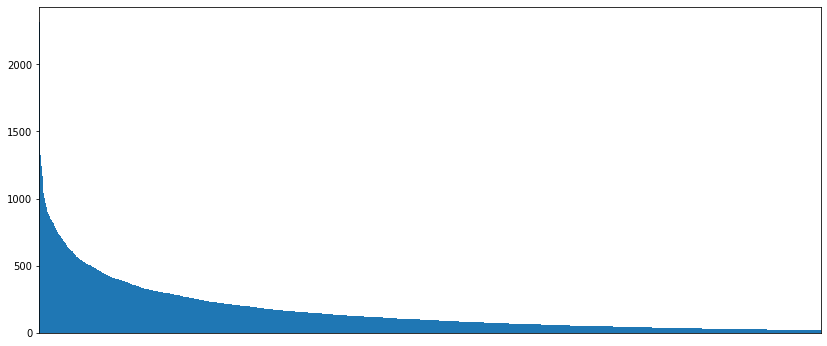

In [ ]:
ratings_per_user.plot(kind='bar', figsize=(14,6), xticks=[], width=1.0)
ratings_per_user.values

In [ ]:
np.sum(ratings_per_user < 100), np.sum(ratings_per_user >= 100)

(3095, 2945)

### Splitting data

In [ ]:
train = []
test_active = []
test_inactive = []

for _, df in ratings_df.groupby(by='UserID'):
    df = df.sort_values('Timestamp')
    train.append(df.iloc[:-5])
    if df.shape[0] < 100:
        test_inactive.append(df.iloc[-5:])
    else:
        test_active.append(df.iloc[-5:])

train_df = pd.concat(train)
test_active_df = pd.concat(test_active)
test_inactive_df = pd.concat(test_inactive)

In [ ]:
trainset = DatasetAutoFolds.load_from_df(train_df[['UserID', 'MovieID', 'Rating']],
                                         Reader(rating_scale=(1,5))).build_full_trainset()

In [ ]:
def get_errors(model, test_df):
    errors = []
    for _, rating in test_df.iterrows():
        est = model.predict(uid=rating['UserID'], iid=rating['MovieID'])[3]
        err = est - rating['Rating']
        errors.append(err)
    return np.array(errors)


def MSE(errors):
    return np.mean(errors**2)


def RMSE(errors):
    return np.sqrt(MSE(errors))

### SVD

In [ ]:
algo = SVD()
algo.fit(trainset)

In [ ]:
errors = get_errors(algo, test_active_df)
print(MSE(errors))
print(RMSE(errors))

0.7690975585319326
0.8769820742363738


In [ ]:
errors = get_errors(algo, test_inactive_df)
print(MSE(errors))
print(RMSE(errors))

0.8963268576573701
0.9467454027653739


### KNN means

In [ ]:
algo = KNNWithMeans()
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
errors = get_errors(algo, test_active_df)
print(MSE(errors))
print(RMSE(errors))

0.8754638419351846
0.9356622477877284


In [ ]:
errors = get_errors(algo, test_inactive_df)
print(MSE(errors))
print(RMSE(errors))

0.9882574721626994
0.9941113982661598


## e)

Calculate top n recommendations for each user  
Coverage - count distinct movies among recommendations  
Diversity - per user, count genres of recommended movies